In [2]:
using BSON: @load
using Flux
using Flux: chunk
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra
using MLDatasets
using Plots


In [3]:
function PLUGIn_PR(G, y, A, max_iter, stepsize, tolerance, out_toggle)
    
    (_, z_dim) = size(Flux.params(G[1])[1]);
    W = I(z_dim)
  
    #normalize the weights of the network
    for i in 1:length(G)
        _, s, _ = svd(Flux.params(G[i])[1])
        W = Flux.params(G[i])[1] * W /s[1]
    end
  
    z = randn(z_dim)
    iter = 1
    succ_error = 1
  
    while iter <= max_iter && succ_error > tolerance
      
      # d gives the PLUGIn direction
      d = ( A * G(z) - y .* sign.(A * G(z)) )
      d = W'*A'* d
      z -= stepsize * d
      succ_error = norm(stepsize * d)
      if iter % out_toggle == 0  
          println("====> In quasi-gradient: Iteration: $iter Successive error: $succ_error")
      end
      iter += 1
    end
    println("====> In quasi-gradient: Iteration: $iter Successive error: $succ_error")
  
    return z
  end

PLUGIn_PR (generic function with 1 method)

In [8]:
function GD_PR(G, y, A, max_iter, stepsize, tolerance, out_toggle)

    z = randn(20)
    iter = 1
    succ_error = 1
    while iter <= max_iter && succ_error > tolerance
        # d gives the PLUGIn direction
        d = gradient(z -> norm(y - abs.(A*G(z)), 2)^2, z)[1]
        z -= stepsize * d
        succ_error = norm(stepsize * d)
        if iter % out_toggle == 0  
            println("====> In GD: Iteration: $iter Successive error: $succ_error")
        end
        iter += 1
    end
    println("====> In GD: Iteration: $iter Successive error: $succ_error")

    return z
end

GD_PR (generic function with 1 method)

In [10]:
#setup a synthetic problem
G = Chain(
    Dense(20, 500, relu, bias = false; initW =(out,in) ->  randn(500, 20)/sqrt(500)),
    Dense(500, 500, relu, bias = false; initW =(out,in) -> randn(500, 500)/sqrt(500)),
    Dense(500, 784, relu, bias = false; initW =(out,in) -> randn(784, 500)/sqrt(784))
)


z = randn(20)
m = 500; A = randn(m, 784)/sqrt(m)
y = abs.(A*G(z)) 

stepsize = 3
tolerance = 1e-14
max_iter = 10000
out_toggle = 1000
z_rec_PLUGIn = PLUGIn_PR(G,y,A, max_iter, stepsize, tolerance, out_toggle)
z_rec_GD = GD_PR(G,y,A, max_iter, stepsize, tolerance, out_toggle)

recov_error_PLUGIn = norm(z/norm(z) - z_rec_PLUGIn/norm(z_rec_PLUGIn))
recon_error_PLUGIn = norm(G(z) - G(z_rec_PLUGIn))
println("PLUGIn: recovery error: $recov_error_PLUGIn, reconstruction error: $recon_error_PLUGIn")

recov_error_GD = norm(z/norm(z) - z_rec_GD/norm(z_rec_GD))
recon_error_GD = norm(G(z) - G(z_rec_GD))
println("Gradient Descent: recovery error: $recov_error_GD, reconstruction error: $recon_error_GD")

====> In quasi-gradient: Iteration: 933 Successive error: 9.821822897647064e-15
====> In GD: Iteration: 151 Successive error: 9.07309377913998e-15
PLUGIn: recovery error: 4.974561941801879e-14, reconstruction error: 6.213016595442539e-14
Gradient Descent: recovery error: 1.0434286002836011e-15, reconstruction error: 2.3197065513777683e-15


Loading model...Done
====> In quasi-gradient: Iteration: 1000 Successive error: 0.0019260490167543967
====> In quasi-gradient: Iteration: 2000 Successive error: 0.0018401767235152974
====> In quasi-gradient: Iteration: 3000 Successive error: 0.0015352694096427877
====> In quasi-gradient: Iteration: 4000 Successive error: 0.0014403288194458296
====> In quasi-gradient: Iteration: 5000 Successive error: 0.0013675033976315548
====> In quasi-gradient: Iteration: 6000 Successive error: 0.0013127143938612641
====> In quasi-gradient: Iteration: 7000 Successive error: 0.0012654181032065192
====> In quasi-gradient: Iteration: 8000 Successive error: 0.0012346362271392936
====> In quasi-gradient: Iteration: 9000 Successive error: 0.0012120659387260867
====> In quasi-gradient: Iteration: 10000 Successive error: 0.0011837906054436532
====> In quasi-gradient: Iteration: 10001 Successive error: 0.0011837906054436532
reconstruction error: 4.825154632272959
====> In GD: Iteration: 1000 Successive error:

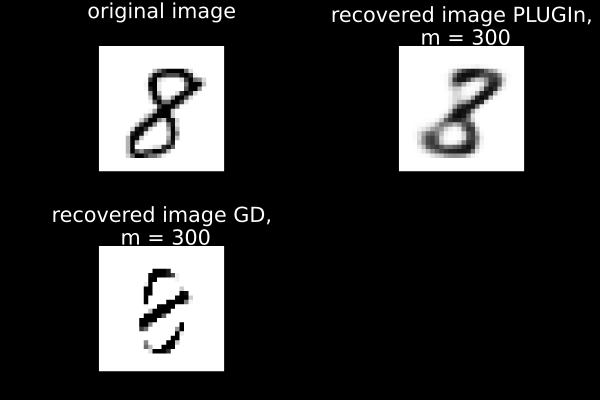

In [11]:
# experiments with MNIST dataset
function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

epoch_to_load = 20
# Load the model and test set loader
encoder_mu, encoder_logvar, decoder = load_model("result", epoch_to_load)

# pick a image in MNIST to denoise
num = 8
batch_size = 64
shuffle_data = true
dataloader = get_train_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x = x_batch[:,i]
noise_level = .1

m = 300; A = randn(m, 784)/sqrt(m)

y = abs.(A*x) + noise_level * randn(m)

stepsize = 1
tolerance = 1e-7
max_iter = 10000
out_toggle = 1000
z_rec_PLUGIn = PLUGIn_PR(decoder, y, A, max_iter, stepsize, tolerance, out_toggle)
error = norm(x - decoder(z_rec_PLUGIn))
println("reconstruction error: $error")

z_rec_GD = GD_PR(decoder, y, A, max_iter, stepsize, tolerance, out_toggle)

recovered_image_PLUGIn = colorview(Gray, reshape(decoder(z_rec_PLUGIn), 28,28)' )
recovered_image_GD = colorview(Gray, reshape(decoder(z_rec_GD), 28,28)' )

true_image = colorview(Gray, reshape(x, 28,28)' );
p1 = plot(true_image, framestyle = :none, bg =:black, title = "original image")
p2 = plot(recovered_image_PLUGIn, framestyle = :none, bg =:black, title = "recovered image PLUGIn,\n m = $m")
p3 = plot(recovered_image_GD, framestyle = :none, bg =:black, title = "recovered image GD,\n m = $m")
plot(p1, p2, p3, layout = 3)
